# Projet TDM : Exploration et prédiction de liens thérapeutiques via Neo4j GDS
**Master MIAGE - Université Paris Nanterre (2025-2026)**
**Binôme :** Mathieu & Sami

## 1. Introduction et problématique : Le repositionnement de médicaments

Le développement de nouvelles molécules pharmaceutiques est un processus extrêmement coûteux et long, nécessitant souvent plus d'une décennie de recherche. Face à ces contraintes, le **repositionnement de médicaments** (*drug repurposing*) apparaît comme une stratégie alternative. Elle consiste à identifier de nouvelles indications thérapeutiques pour des médicaments déjà approuvés.

La complexité des mécanismes biologiques rend cette identification difficile par les méthodes traditionnelles.Les interactions entre gènes, maladies, composés chimiques et voies biologiques forment un système complexe qu'il convient de modéliser sous forme de graphe.

Ce projet utilise **Neo4j Graph Data Science (GDS)** pour permettre l'extraction de connaissances nouvelles via des algorithmes d'analyse de graphes et d'apprentissage automatique.

Notre approche méthodologique s'articule autour de deux axes :
1. **L'approche utilisateur standard (Médecin) :** Nous exploitons le graphe comme base de connaissances factuelle pour répondre à des interrogations cliniques immédiates.
2. **L'approche analyste de données (Chercheur) :** Déploiement d'un pipeline de data science pour inférer des relations non explicites dans les données.

Dans le chapitre *2*, nous décrivons le contexte du dataset utilisé. Le Chapitre *3* donne la modélisation des données. Le chapitre *4*, détaille le processus d'installation du dataset. Le Chapitre *5* mets en évidence des requêtes Cypher utilisés pour un utilisateur simple. Dans le chapitre *6* nous nous mettons dans la peau d'un analyste de données en utilisant des algorithmes d'intelligence artificielle avec la bibliothèque Graph Data Science.

## 2. Choix du jeu de données

Pour répondre à cette problématique, notre choix s'est porté sur le dataset **Hetionet v1.0**.

**Source et accès :**
Le jeu de données est accessible publiquement sur le dépôt GitHub officiel du projet : [https://github.com/hetio/hetionet](https://github.com/hetio/hetionet/blob/main/hetnet/json/hetionet-v1.0.json.bz2).

Ce dataset représente des connaissances biomédicales agrégées reliant des entités hétérogènes telles que les maladies, les gènes, les composés chimiques (médicaments) et les voies biologiques. Chaque entité est représentée par un nœud, et les relations décrivent des liens biologiques ou pharmacologiques entre ces entités.

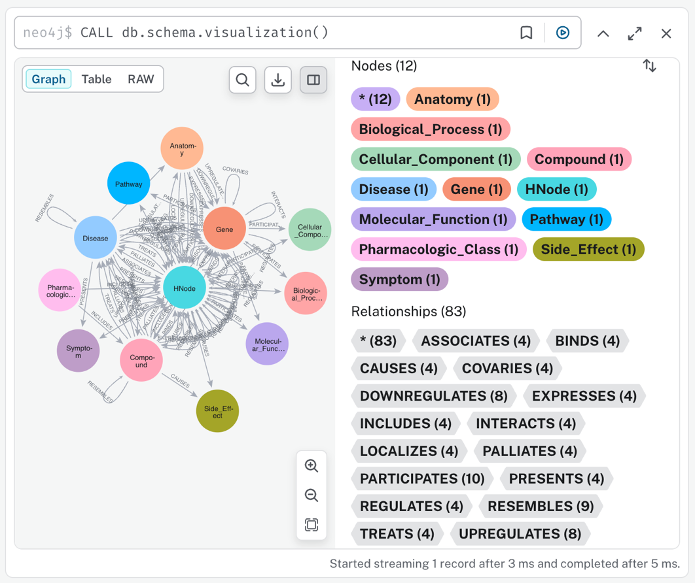

## 3. Présentation et modélisation des données

Le modèle de données de Hetionet est structuré autour de nœuds et de relations orientées décrivant des liens biologiques ou pharmacologiques.

### 3.1. Nœuds
Chaque entité est représentée par un nœud portant un label spécifique. Le tableau ci-dessous détaille la sémantique des types de nœuds présents dans le graphe:

| Type de Nœud (Label) | Description |
| :--- | :--- |
| **Disease** | Maladies |
| **Gene** | Gènes |
| **Compound** | Médicaments / composés chimiques |
| **Pathway** | Voies biologiques |
| **Anatomy** | Parties anatomiques |
| **Symptom** | Symptômes |
| **Side_Effect** | Effets secondaires |
| **Pharmacologic_Class** | Classes pharmacologiques |
| **Biological_Process** | Processus biologiques |
| **Molecular_Function** | Fonctions moléculaires |
| **Cellular_Component** | Composants cellulaires |
| **HNode** | Label générique commun à tous les nœuds (ajout technique) |

*Note technique : Le label générique `HNode` a été ajouté lors de l'importation pour unifier l'ensemble des entités et faciliter la création d'index globaux.*

### 3.2. Relations
Les interactions entre ces nœuds sont typées sémantiquement. Le graphe comporte 83 types de relations orientées. Les principales relations exploitées dans notre analyse sont les suivantes:

| Type de Relation | Signification |
| :--- | :--- |
| **TREATS** | Un médicament traite une maladie |
| **ASSOCIATES** | Association entre gène et maladie |
| **BINDS** | Un composé se lie à un gène |
| **INTERACTS** | Interaction entre entités biologiques |
| **RESEMBLES** | Similarité entre maladies |
| **CAUSES** | Cause un symptôme ou effet |
| **UPREGULATES / DOWNREGULATES** | Régulation génétique |
| **PALLIATES** | Soulage une maladie |


## 4. Protocole d'Installation et import des données

Cette section détaille l'ensemble des opérations techniques nécessaires à l'initialisation de l'environnement, garantissant la reproductibilité de l'analyse.

### 4.1. Pré-requis matériels et logiciels

* **Moteur Neo4j :** Version 5.x avec l'extension **Graph Data Science (GDS)** installée et activée.
* **Mémoire (RAM) :** La `heap size` (taille de la mémoire vive allouée à la base) doit être ajustée. Nous avons mis 3Go sur nos machines. Cette configuration est essentielle pour charger le graphe en mémoire pour les projections GDS, sans quoi les algorithmes de Link Prediction échoueront. Cette modification se fait dans le fichier .conf de la database
* **Dépendances python :** Installation des librairies `neo4j`, `graphdatascience` et `pandas`.

### 4.2. Installation des dépendances python
La commande suivante permet d'installer toutes les dépendances requises pour l'exécution du Notebook.

In [ ]:
# Installation des librairies Python requises
# Le "%" permet d'exécuter la commande dans l'environnement Shell du Notebook
%pip install graphdatascience pandas neo4j

Le script suivant réalise séquentiellement la connexion au driver, la lecture du flux compressé, le nettoyage de la base , la création des contraintes d'intégrité (indexation) et l'importation par lots des nœuds et des relations.

Il ne faut pas oublier de mettre votre mot de passe dans la variable DB_PASS

In [ ]:
import json
import os
import bz2
from graphdatascience import GraphDataScience

# ==========================================
# 1. CONFIGURATION DE L'ENVIRONNEMENT
# ==========================================
# Paramètres de connexion à l'instance locale Neo4j
DB_URL = "bolt://localhost:7687"
DB_USER = "neo4j"
DB_PASS = "mon super mot de passe"  # À modifier

try:
    # Initialisation du client GDS
    gds = GraphDataScience(DB_URL, auth=(DB_USER, DB_PASS))
    print(f"[INFO] Connexion établie avec succès à Neo4j (Version GDS : {gds.version()})")
except Exception as e:
    raise Exception(f"[ERREUR] Échec de connexion au serveur Neo4j. Vérifiez l'adresse, le mot de passe et l'état de la base. Détails : {e}")

In [ ]:
# ==========================================
# 2. LECTURE DU FICHIER SOURCE
# ==========================================
filename = "hetionet-v1.0.json.bz2"

if not os.path.exists(filename):
    raise Exception(f"[ERREUR] Fichier source introuvable : '{filename}'.")

print(f"[INFO] Lecture et décompression du fichier '{filename}'...")
# Lecture du flux bz2
with bz2.open(filename, "rt", encoding='utf-8') as f:
    data = json.load(f)

print(f"[INFO] Métadonnées chargées : {len(data['nodes'])} nœuds et {len(data['edges'])} relations identifiés.")

# ==========================================
# 3. INITIALISATION DE LA BASE DE DONNÉES
# ==========================================
print("\n[INFO] Réinitialisation de la base de données (Nettoyage)...")
gds.run_cypher("MATCH (n) DETACH DELETE n")

print("[INFO] Configuration des index et contraintes d'unicité...")
# Création d'une contrainte d'unicité sur l'ID du label générique HNode
try:
    gds.run_cypher("CREATE CONSTRAINT IF NOT EXISTS FOR (n:HNode) REQUIRE n.id IS UNIQUE")
except:
    gds.run_cypher("CREATE CONSTRAINT ON (n:HNode) ASSERT n.id IS UNIQUE")

# ==========================================
# 4. IMPORTATION DES NOEUDS
# ==========================================
print("\n[INFO] Début de l'importation des NOEUDS...")
nodes_by_kind = {}

# Pré-traitement : regroupement des nœuds par type
for node in data['nodes']:
    kind = node['kind'].replace(' ', '_')
    if kind not in nodes_by_kind:
        nodes_by_kind[kind] = []
    nodes_by_kind[kind].append({'id': node['identifier'], 'name': node['name']})

# Insertion par lots
for kind, batch in nodes_by_kind.items():
    query = f"UNWIND $batch AS row CREATE (n:`{kind}`:HNode) SET n.id = row.id, n.name = row.name"
    
    batch_size = 10000
    for i in range(0, len(batch), batch_size):
        gds.run_cypher(query, params={'batch': batch[i:i+batch_size]})
    print(f"   > Type '{kind}' : Importation terminée.")

# ==========================================
# 5. IMPORTATION DES RELATIONS
# ==========================================
print("\n[INFO] Début de l'importation des RELATIONS...")
edges_by_kind = {}

# Pré-traitement des relations
for edge in data['edges']:
    kind = edge['kind'].replace(' ', '_').upper()
    if kind not in edges_by_kind:
        edges_by_kind[kind] = []
    edges_by_kind[kind].append({
        'source': edge['source_id'][1], 
        'target': edge['target_id'][1]
    })

count_rels = 0
total_rels = len(data['edges'])

for kind, batch in edges_by_kind.items():
    # Matching optimisé sur l'index HNode
    query = f"""
    UNWIND $batch AS row
    MATCH (s:HNode {{id: row.source}}), (t:HNode {{id: row.target}})
    CREATE (s)-[r:`{kind}`]->(t)
    """
    
    batch_size = 5000 
    for i in range(0, len(batch), batch_size):
        gds.run_cypher(query, params={'batch': batch[i:i+batch_size]})
        count_rels += len(batch[i:i+batch_size])
        
        if count_rels % 50000 == 0:
            print(f"   > Progression : {count_rels} / {total_rels} relations créées...")

print(f"\n[SUCCÈS] Pipeline d'ingestion terminé. Base de données Hetionet prête.")

La cellule ci-dessous permet de vérifier que l'ingestion des données est bien effectuée.

In [ ]:
print("[INFO] Vérification de l'importation en cours...")

# Comptage des nœuds
nodes_count = gds.run_cypher("MATCH (n) RETURN count(n) as count")
total_nodes = nodes_count['count'][0]

# Comptage des relations
rels_count = gds.run_cypher("MATCH ()-[r]->() RETURN count(r) as count")
total_rels = rels_count['count'][0]

print("\n[SUCCÈS] Vérification de l'importation terminée. Voici l'état du graphe :")
print(f"   Total Nœuds Importés : {total_nodes:,}")
print(f"   Total Relations Importées : {total_rels:,}")

# 5. Cas d'usages utilisateur simple (le médecin)

Dans cette section, nous adoptons la perspective du clinicien qui utilise le graphe comme une base de connaissances établie.

Le médecin cherche ici une solution thérapeutique pour une pathologie complexe : la **sclérose en plaques** (*multiple sclerosis*). Ce scénario illustre l'approche descriptive de la donnée, où l'utilisateur ne peut naviguer que dans les relations déjà existantes.

### 5.1. Inventaire des traitements officiels

La première étape pour le médecin consiste à lister les molécules qui traitent officiellement cette pathologie. Cette requête Cypher permet d'extraire les relations directes de type `TREATS`.

In [ ]:
# 5.1 - Médicaments traitant officiellement la sclérose en plaques
query_inventory = """
MATCH (d:Disease {name: 'multiple sclerosis'})<-[:TREATS]-(c:Compound)
RETURN c.name AS Medicament, d.name AS Maladie, c.description AS Description
ORDER BY Medicament
"""

df_inventory = gds.run_cypher(query_inventory)
print("Traitements officiels répertoriés :")
display(df_inventory)

### 5.2. Compréhension de la biologie sous-jacente

Pour approfondir son analyse, le médecin examine les mécanismes moléculaires directement associés à la pathologie. Il identifie les gènes liés à la **sclérose en plaques**, ce qui permet de visualiser les cibles biologiques impliquées dans la maladie, indépendamment des traitements actuels. Cette étape va notamment permettre au médecin d'adapter son traitement en fonction du génome de son patient.

In [ ]:
# 5.2 - Gènes associés à la Sclérose en plaques
query_context = """
MATCH (d:Disease {name: 'multiple sclerosis'})-[:ASSOCIATES]-(g:Gene)
RETURN d.name AS Maladie, g.name AS Gene_Associe
ORDER BY Gene_Associe
LIMIT 15
"""

df_context = gds.run_cypher(query_context)
display(df_context)

### 5.3. Analyse des risques liés aux effets secondaires de l'Azathioprine

Pour compléter son diagnostic, le médecin évalue les risques liés au traitement standard. Nous interrogeons le graphe pour extraire les effets secondaires documentés de l'**Azathioprine**.

In [ ]:
# 5.3 - Analyse des effets secondaires de l'Azathioprine

query_safety = """
MATCH (c:Compound {name: 'Azathioprine'})-[:CAUSES]->(se:Side_Effect)
RETURN c.name AS Medicament, se.name AS Effet_Secondaire
ORDER BY Effet_Secondaire
LIMIT 15
"""

df_safety = gds.run_cypher(query_safety)
print("Effets secondaires documentés pour l'Azathioprine :")
display(df_safety)


# 6. Cas d'usage sur l'analyste de données
Ce chapitre est divisé en deux sections. La première section mets en évidence l'utilisation du machine learning et d'un algorithme d'embeddings utilisé par Sami. La seconde section présente un algorithme de deep learning présenté par Mathieu.

# 6.1 Partie théorique - Sami

Nous voulons découvrir si des médicaments déjà existants soignant une maladie A pourraient, être efficaces pour soigner une autre maladie B. Pour cela, j'ai regardé les algorithmes proposés par Neo4j GDS dans leur documentation officielle. Et deux, ont été retenu pour cette analyse théorique, FastRP et le pipeline Link Predict avec des algorithmes deux classifications, `Random Forest` et `Logistic Regression`.

Ma première intention était de me focaliser sur la relation entre (Médicament) et (Maladie). Cependant, avec uniquement (Médicament)-(Maladie), le modèle joue aux devinettes avec très peu d'indices parce qu'il ne contient que l'info "Je soigne telle maladie".
Pour relier le Médicament A à la Maladie B, l'IA va seulement regarder si A ressemble aux autres médicaments qui soignent B. C'est faible.

Si nous ajoutons les gènes, l'anatomie, les effets secondaires, le vecteur du médicament devient très enrichis. "Je soigne telle maladie, MAIS je cible aussi tel gène, je provoque tel effet secondaire et j'agis dans tel organe."

Deux médicaments qui n'ont rien en commun en apparence (ne soignent pas la même maladie) pourraient se retrouver très proches vectoriellement parce qu'ils ciblent le même gène. Le modèle pourra alors dire que "Ce médicament soigne le cancer, et cet autre médicament cible le même gène, donc il a de fortes chances de soigner le cancer aussi."

Pour ces raisons, j'ai choisi d'utiliser le dataset complet pout la détection de médicaments potentiellement capable de soigner une autre maladie que celle qui lui était destinée.

La documentation le précise explicitement : « Il peut être utile de générer des intégrations de nœuds avec FastRP comme étape de propriété de nœud dans un pipeline d'apprentissage automatique (comme les pipelines de prédiction de lien [...]) »

Pipeline :
1. Je charge le graphe en mémoire avec des relations non orientées.

2. Je calcule les embeddings pour capturer la topologie avec l'algorithme FastRP.

3. Je divise ensuite les liens existants en ensembles d'entraînement, de test et "le reste".
On garde 32% des liens juste pour définir la "structure" du graphe pour FastRP, 48% pour apprendre des exemples, et 20% pour vérifier si ça marche. Ça sert à ce que FastRP puisse calculer des vecteurs, sans donner la réponse au modèle d'entraînement.

4. Le programme combine le vecteur FastRP du médicament et celui de la maladie.

5. Le modèle apprend à prédire le lien basé sur cette combinaison grâce au classifieur.`.

Le pipeline `Link Prediction` prend les vecteurs générés par `FastRP` et cherche des motifs. Il va combiner le vecteur du Médicament A et celui de la Maladie B pour voir si leur "mélange" ressemble à un lien TREATS valide.


## Description de l'algorithme FastRP

FastRP (Fast Random Projection) est un algorithme d'intégration de nœuds (node embedding) appartenant à la famille des
algorithmes de projection aléatoire. L'algorithme est conçu pour fonctionner de manière optimale sur des graphes *non dirigés* pour produire les meilleures intégrations prédictives (notre dataset est orienté).

L'algorithme attribue initialement des vecteurs aléatoires à tous les nœuds. Ensuite, il procède par itérations. À chaque étape, il effectue une moyenne des vecteurs sur les voisinages des nœuds. Puis l'intégration finale d'un nœud est une combinaison linéaire de ses vecteurs initiaux et des moyennes de ses voisins sur plusieurs degrés.

L'objectif c'est de garantir que deux nœuds ayant des voisinages similaires (topologie proche) obtiennent des vecteurs d'intégration similaires, tandis que des nœuds dissemblables auront des vecteurs distants.

## Objectif dans le contexte du projet

L'objectif principal de l'utilisation de FastRP ici est la réduction de la dimensionnalité tout en conservant l'information structurelle du graphe Hetionet. Pour cela, on va convertir toutes les entités biologiques  en vecteurs numériques exploitables par des algorithmes de machine learning. Ensuite on va capturer les relations d'ordre supérieur en moyennant sur les voisinages. FastRP nous permet d'exploiter les relations indirectes. C'est intéressant pour le repositionnement des médicaments, où un médicament est relié à une maladie via des intermédiaires (gènes, effets secondaires...).

## Les paramètres de FastRP

L'algorithme FastRP met à dispositions 4 paramètres tels que `embeddingDimension`, `iterationWeights`, `nomalizationStrenght` et `orientation`.

Le paramètre `embeddingDimension` définit la longueur du vecteur de sortie. Selon la documentation, une valeur typique est une puissance de deux entre 128 et 1024. Pour un graphe de l'ordre de $10^5$ nœuds, une dimension d'au moins 256 est recommandée pour capturer suffisamment d'information. Étant donné que notre graphe a 4.5M relations, nous avons choisi une dimension de 512.

`iterationWeights` est une liste de nombres qui contrôle le nombre d'itérations et leur impact. Le nombre d'itération correspond à la distance des voisins pris en compte (par exemple, 1 itération = voisins directs, 2 itérations = voisins de second degré etc...). Selon la documentation, il est conseillé d'utiliser au moins trois itérations pour capturer un voisinage significatif sans aller trop loin car ça pourrait ajouter du bruit. J'ai donc défini iterationWeights à 3.

`nomalizationStrenght` contrôle l'influence du degré des nœuds (leur nombre de connexions) sur l'embedding. Une valeur négative permet de diminuer l'importance des voisins à très haut degré, ce qui peut être utile pour éviter que des gènes omniprésents ne biaisent les résultats.

Bien que l'algorithme FastRP soit plus optimale sur des graphes non orientés car l'information circule librement, et donc crée des profils d'embeddings beaucoup plus riche. Le paramètre `orientation` sert à définir quelle direction des relations doit être prise en compte lors de la création du graphe en mémoire pour l'algorithme. Le choix de la bonne orientation est très important, parce que selon la documentation, cela peut avoir un très grand impact sur la qualité des résultats. Le paramètre offre trois options : `UNDIRECTED` (recommandé) elle compte les relations dans les deux sens, `NATURAL` si les relations sortantes sont informatives pour la tâche de prédiction. Une information sortante est une route qui part de (Moi) -> (Voisin). Je peux aller voir le voisin, j'ai accès à ses informations, mais pas lui. On dit que j'influence le voisin.
`REVERSE` si les relations entrantes sont informatives. Une information entrante est une route qui part de (Voisin) -> (Moi).

#### Exemple avec notre dataset :

Supposons que nous ayons la relation suivante : (Médicament) ---TREATS---> (Maladie).
Si le paramètre `orientation` est en `NATURAL` alors un médicament peut voir la maladie qu'il soigne, mais la maladie ne peut pas voir le médicament en retour car la flèche est dans le mauvais sens. Le médicament envoie son information vers la maladie. Le vecteur de la maladie se modifie pour ressembler au médicament, mais le médicament ne reçoit rien en retour. Son vecteur ne se modifie par pour ressembler à la maladie. Par conséquent, Ils ne finissent pas dans la même zone de l'espace vectoriel puisque le médicament reste à sa place tandis que la maladie bouge. Et cela rend la prédiction de lien (basée sur la proximité) très difficile.
L'avantage de `UNDIRECTED` est que l'information circule dans les deux sens. Le médicament tire la maladie vers lui, et la maladie tire le médicament vers elle. Ils convergent vers un point commun, et cette proximité mutuelle permet à l'algorithme de dire que tel médicament est très proche spatialement de telle maladie, donc il devrait probablement la soigner.

### Reproductibilité

La documentation précise que pour garantir la reproductibilité, il faut fixer une graine `randomSeed`. J'ai choisi 42 pour mon dataset.

## Description de Link Predict

La prédiction de liens (Link Prediction) est une tâche d'apprentissage automatique supervisé appliquée aux graphes. Elle consiste à entraîner un modèle pour apprendre où des relations devraient exister entre des paires de nœuds.

Dans Neo4j GDS, cette fonctionnalité est gérée par des pipelines. Un pipeline offre un flux de travail de bout en bout ("end-to-end workflow") qui automatise trois phases :

1. Extraction de données : Le graphe est divisé en ensembles de fonctionnalités, d'entraînement et de test. Des exemples positifs (liens existants) et négatifs (nœuds non adjacents) sont dérivés.

2. Enrichissement : Les nœuds sont enrichis avec de nouvelles propriétés en exécutant des algorithmes (comme FastRP) sur le graphe.

3. Création de features de liens : Les propriétés des deux nœuds d'une paire (Source et Cible) sont combinées mathématiquement pour créer un vecteur unique représentant le lien potentiel.

Une fois entraîné, le modèle est stocké dans le catalogue et peut être utilisé pour inférer la probabilité d'existence d'une relation entre deux nœuds qui ne sont pas encore connectés.

## Objectifs dans le contexte du projet

L'objectif ici est purement prédictif, nous devons passer de la description avec FastRP à la décision.

Le but est d'appliquer le modèle pour identifier des relations manquantes. Dans notre cas, déterminer si un médicament et une maladie, actuellement non reliés dans la base, devraient l'être.

Aussi, dans les graphes biomédicaux il y a beaucoup plus de paires de nœuds non connectées que de paires connectées. Le pipeline est conçu pour gérer ce déséquilibre via des métriques spécifiques comme l'AUCPR.

L'algorithme ne répond pas par `Oui` ou `Non`, mais fournit une probabilité (un score de confiance). Cela permet de trier les candidats médicaments du plus probable au moins probable.

## Les paramètres de Link Predict

Le pipeline nécessite la configuration de plusieurs étapes pour transformer les données brutes en prédictions fiables.

Le paramètre `configureSplit` permet de séparer les relations existantes en ensembles d'entraînement (train) et de test (test). Généralement on utilise 80/20.

`negativeSamplingRatio` permet de générer artificiellement des "exemples négatifs" (ce qui n'existe pas) pour apprendre. Ce ratio définit combien de non-liens on ajoute pour chaque vrai lien. Par exemple, pour des graphes très déséquilibrés, ajuster ce paramètre permet de contrôler la précision du modèle sur les classes rares.

Une fois que FastRP a donné un vecteur au Médicament ($f_u$) et à la Maladie ($f_v$), le pipeline doit les "mélanger" pour que le classifieur puisse les étudier. Pour cela, on utilise le paramètre `addFeature` qui propose plusieurs méthodes de combinaison :

1. HADAMARD : Multiplication élément par élément.
2. L2 : Distance Euclidienne.
3. COSINE : Similarité cosinus.

Le choix de la méthode (souvent Hadamard ou L2) détermine comment le modèle perçoit la compatibilité entre les deux nœuds.

`addModelCandidate` permet de définir quels algorithmes de classification seront testés via la validation croisée pour garder le meilleur. Les modèles disponibles sont la Régression Logistique, le Random Forest et le Perceptron Multicouche (MLP - réseau de neurones).

- gds.beta.pipeline.linkPrediction.addLogisticRegression
- gds.beta.pipeline.linkPrediction.addRandomForest
- gds.alpha.pipeline.linkPrediction.addMLP

Il faut pouvoir évaluer notre modèle, et pour cela on utilise le paramètre `metrics`. La documentation recommande d'utiliser `AUCPR` car l'AUCPR est beaucoup plus adaptée aux données déséquilibrées (ce qui est typique du repositionnement de médicaments où les vrais traitements sont rares par rapport à toutes les combinaisons possibles).

## Script python

In [ ]:
# Connexion à Neo4j
from graphdatascience import GraphDataScience

URI = "bolt://localhost:7687"
AUTH = ("neo4j", "Sami78300!")

gds = GraphDataScience(URI, auth=AUTH)
print(f"Connecté à GDS version : {gds.version()}")

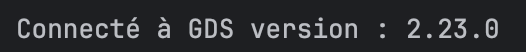

In [ ]:
# Projection du graphe complet en mémoire non orienté
graph_name = 'drug_repurposing_graph'

try:
    gds.graph.drop(graph_name)
    print(f"Graphe existant '{graph_name}' supprimé.")
except:
    pass

# Récupération dynamique des noeuds. Je liste explicitement les types de noeuds pour éviter le type générique __ALL__ lors de la classification.
labels_df = gds.run_cypher("CALL db.labels()")
node_list = labels_df['label'].tolist()
print(f"Labels trouvés : {node_list}")

# Récupération des relations
rel_types_df = gds.run_cypher("CALL db.relationshipTypes()")
rel_list = rel_types_df['relationshipType'].tolist()
rel_projection_config = {
    rel: {'orientation': 'UNDIRECTED'}
    for rel in rel_list
}

# Je passe node_list au lieu de ['*']
G, result = gds.graph.project(
    graph_name,
    node_list,
    rel_projection_config
)

print(f"Graphe complet '{G.name()}' créé avec succès.")
print(f"Nombre de nœuds : {G.node_count()}")
print(f"Nombre de relations : {G.relationship_count()}")

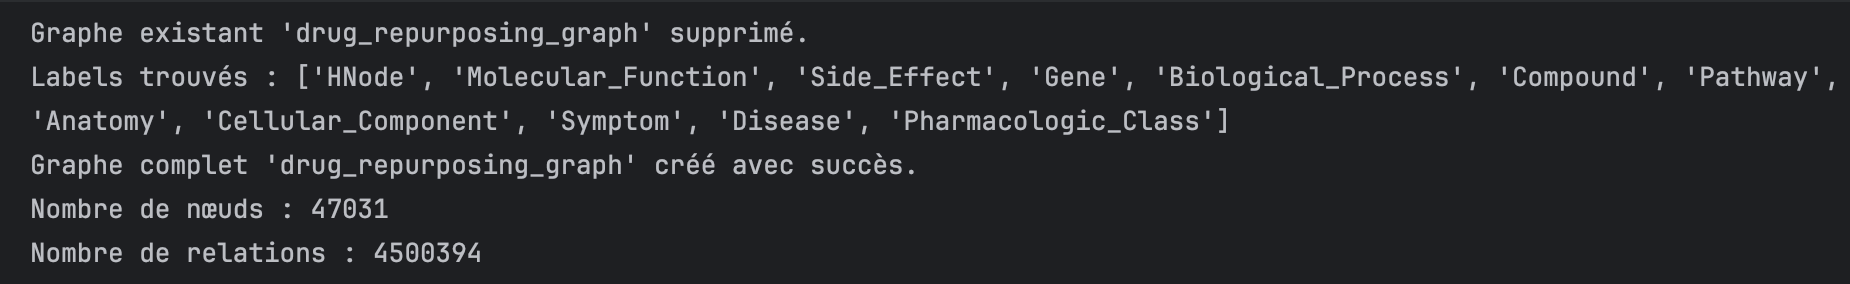

In [ ]:
# Création du Pipeline et configuration de FastRP
pipe_name = 'pipe_drug_repurposing'

try:
    gds.run_cypher("CALL gds.pipeline.drop($name)", params={"name": pipe_name})
    print(f"Ancien pipeline '{pipe_name}' supprimé avec succès.")
except Exception as e:
    if "Procedure call provided an invalid argument" not in str(e):
        print(f"Info suppression : {e}")

# Création du pipeline
pipe, result = gds.beta.pipeline.linkPrediction.create(pipe_name)

# Ajout de l'étape FastRP
pipe.addNodeProperty('fastRP', **{
    'mutateProperty': 'embedding',
    'embeddingDimension': 512,
    'iterationWeights': [0.5, 1, 1, 1],
    'normalizationStrength': 0.5,
    'randomSeed': 42
})

print("Pipeline créé et FastRP configuré.")
print(pipe.node_property_steps())

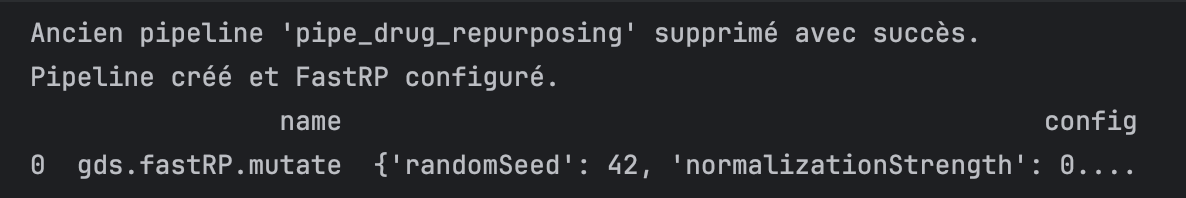

In [ ]:
# Ajout de la feature de lien

# On utilise la méthode 'HADAMARD' pour combiner les vecteurs.
# On lui précise d'utiliser la propriété 'embedding' (celle créée par FastRP juste avant).
pipe.addFeature('HADAMARD', nodeProperties=['embedding'])

print("Feature de lien 'HADAMARD' ajoutée avec succès.")

print(pipe.feature_steps())

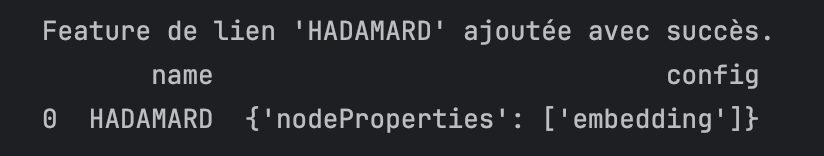

In [ ]:
# Configuration du Split et Ajout des Modèles Candidats

# Configuration de la séparation des données (Split)
pipe.configureSplit(
    testFraction=0.2,        # 20% des liens pour le test final
    trainFraction=0.6,       # 60% du reste pour l'entraînement
    negativeSamplingRatio=1.0
)

# Ajout des modèles candidats
# Candidat A : Random Forest (Forêts aléatoires). Il est souvent très performant sur ce type de données
pipe.addRandomForest(numberOfDecisionTrees=100)

# Candidat B : Régression Logistique (pas efficace donc je ne l'utilise pas)
# pipe.addLogisticRegression()

print("Split configuré et 2 modèles candidats (Random Forest & Logistic Regression) ajoutés.")

print(pipe.parameter_space())

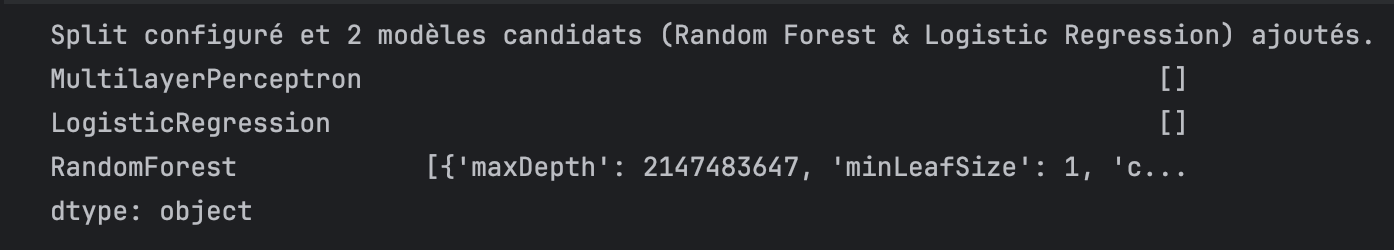

In [ ]:
# Entraînement du pipeline
model_name = 'lp_drug_model'

try:
    gds.run_cypher("CALL gds.model.drop($name)", params={"name": model_name})
    print(f"Ancien modèle '{model_name}' supprimé (via Cypher).")
except Exception:
    pass

print("Entraînement en cours sur le graphe complet... (Patience !)")

# Le pipeline prend le graphe G en entrée
model, stats = pipe.train(
    G,
    modelName=model_name,
    metrics=['AUCPR'],
    targetRelationshipType='TREATS',
    randomSeed=42,
    # On force le modèle à ne regarder que les liens Médicament -> Maladie
    sourceNodeLabel='Compound',
    targetNodeLabel='Disease'
)

print("-" * 30)
print(f"Modèle gagnant : {stats['modelInfo']['bestParameters']['methodName']}")
print(f"Score AUCPR (Test) : {stats['modelInfo']['metrics']['AUCPR']['test']:.4f}")
print("-" * 30)

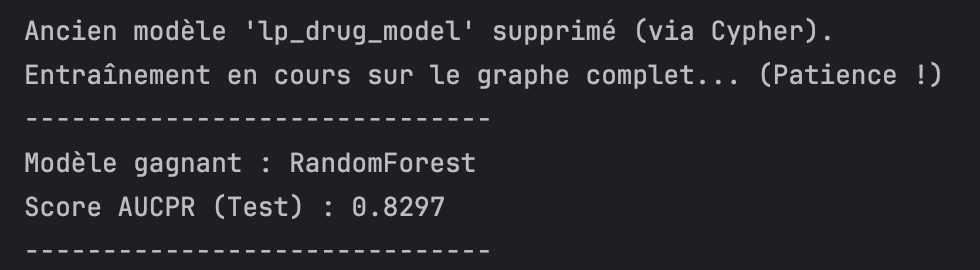

In [ ]:
# Prédiction des nouveaux liens

# On ne veut que les liens qui partent d'un 'Compound' vers une 'Disease'
query = """
CALL gds.beta.pipeline.linkPrediction.predict.stream($graph_name, {
  modelName: $model_name,
  topN: 10,
  threshold: 0.50,
  // --- CONTRAINTES CRUCIALES ---
  sourceNodeLabel: 'Compound',
  targetNodeLabel: 'Disease'
})
YIELD node1, node2, probability
RETURN
    gds.util.asNode(node1).name AS Medicament,
    gds.util.asNode(node2).name AS Maladie_Cible,
    probability
ORDER BY probability DESC
"""

params = {
    "graph_name": "drug_repurposing_graph",
    "model_name": "lp_drug_model"
}

print("=== TOP 10 DES REPOSITIONNEMENTS ===")
results = gds.run_cypher(query, params)
print(results)

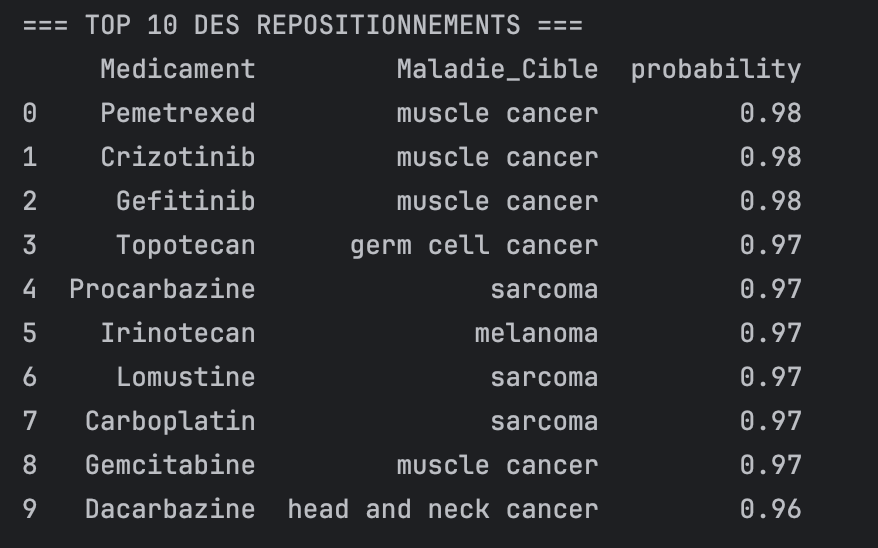

In [ ]:
# Outil de Recherche par Maladie
search_disease = "multiple sclerosis"

print(f"Recherche de traitements potentiels pour : {search_disease}...")

check_query = """
MATCH (d:Disease)
WHERE d.name = $name
RETURN d.name AS found_name LIMIT 1
"""
check = gds.run_cypher(check_query, params={"name": search_disease})

if check.empty:
    print(f"ERREUR : La maladie '{search_disease}' n'a pas été trouvée dans Hetionet.")
    print("Astuce : Vérifie l'orthographe en anglais (ex: 'Alzheimer disease' et pas 'Alzheimer').")
else:
    print(f"Maladie trouvée. Lancement de l'IA...")

    # Prédiction ciblée
    # On demande un topN large (50k) pour être sûr de trouver des candidats pour cette maladie puis on filtre avec WHERE
    query = """
    CALL gds.beta.pipeline.linkPrediction.predict.stream($graph_name, {
      modelName: $model_name,
      topN: 50000,
      threshold: 0.50,
      sourceNodeLabel: 'Compound',
      targetNodeLabel: 'Disease'
    })
    YIELD node1, node2, probability
    WITH gds.util.asNode(node1) AS Medicament, gds.util.asNode(node2) AS Maladie, probability

    WHERE Maladie.name = $target_name

    RETURN
        Medicament.name AS Medicament_Suggere,
        probability as Confiance_IA
    ORDER BY probability DESC
    LIMIT 10
    """

    params = {
        "graph_name": "drug_repurposing_graph",
        "model_name": "lp_drug_model",
        "target_name": search_disease
    }

    results = gds.run_cypher(query, params)

    if results.empty:
        print("Aucun candidat trouvé au-dessus de 50% de probabilité dans le scope de recherche.")
    else:
        print(f"\nTOP CANDIDATS POUR : {search_disease.upper()}")
        print(results)

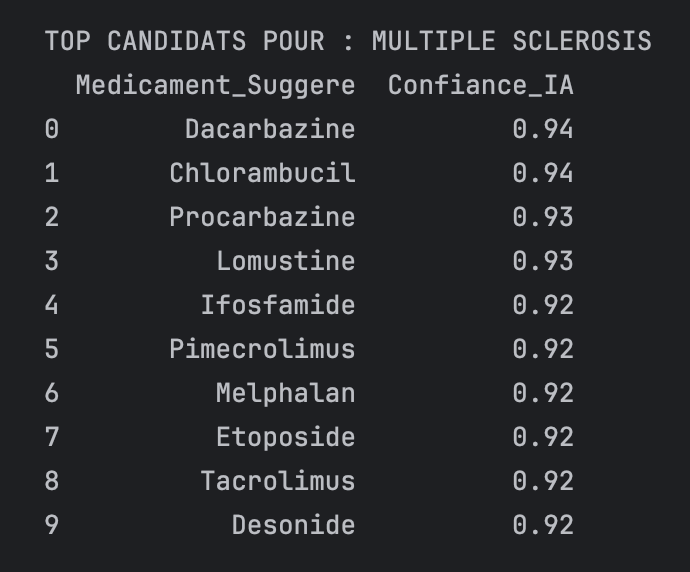

## Analyses des résultats

Ces expériences ont éte exécuté sur un MacBook M4 Max de 36Go RAM, j'ai fixé la graine d'aléatoire à 42 pour la reproductibilité.

Dans ce pipeline, j'utilise l'algorithme de random forest car celui-ci donne des résultats plus concluant contrairement à la régression logistique. Cela s'explique par le fait que la régression logistique est un modèle linéaire. Elle essaie de séparer les "bons médicaments" des "mauvais" en traçant une ligne droite parfaite (ou un plan plat) dans l'espace de 512 dimensions. Or, la biologie n'est pas linéaire. Un médicament n'agit pas selon une simple addition de facteurs, mais selon des interactions complexes. L'ajout des données contextuelles (Gènes, Pathways, Anatomie...) a créé un espace vectoriel complexe où les relations ne sont pas séparables par une simple ligne droite. De ce fait, la régression logistique échoue donc à capturer ces nuances, là où le random forest (modèle non-linéaire) y arrive mieux car il peut dire "Si tu es dans le coin en haut (Gène A), ALORS tu es rouge. MAIS si tu es en bas (Gène B) ET à droite (Voie C), tu es aussi rouge."
Il capture la complexité des formes "tordues" de la biologie.

### Résultats de random forest :

Après avoir testé une approche linéaire classique qui était peu concluante (50% de chance que le médicament soit soigne la maladie), j'ai entraîné un modèle de Random Forest pour tenter de capturer la complexité non-linéaire des données biologiques. Voici les conclusions tirées de cette expérimentation.

Le modèle affiche un score AUCPR de 0.8297 sur l'ensemble de test. Le Random Forest produit des probabilités tranchées, avec un Top 10 dépassant les 0.95 de confiance. Cela indique que le modèle parvient à identifier des signaux forts et distinctifs dans les vecteurs de 512 dimensions.

Étant donné que je ne suis pas expert sur le sujet, j'ai demandé à Gemini si mes prédictions étaient corrects.
Pour valider la pertinence médicale du modèle, j'ai isolé les prédictions pour la sclérose en plaques (multiple sclerosis) et ai fournis mes résultats à Gemini.

Selon Gemini, le modèle suggère en priorité des immunosuppresseurs puissants et des agents alkylants (Dacarbazine, Chlorambucil, Melphalan). Ces traitements sont principalement utilisés pour des chimiothérapies, mais ils correspondent historiquement aux stratégies de suppression du système immunitaire utilisées dans les formes graves de la maladie. L'IA a donc correctement relié le mécanisme immunosuppression à la pathologie auto-immune.

## Résultat de Logistic regression :

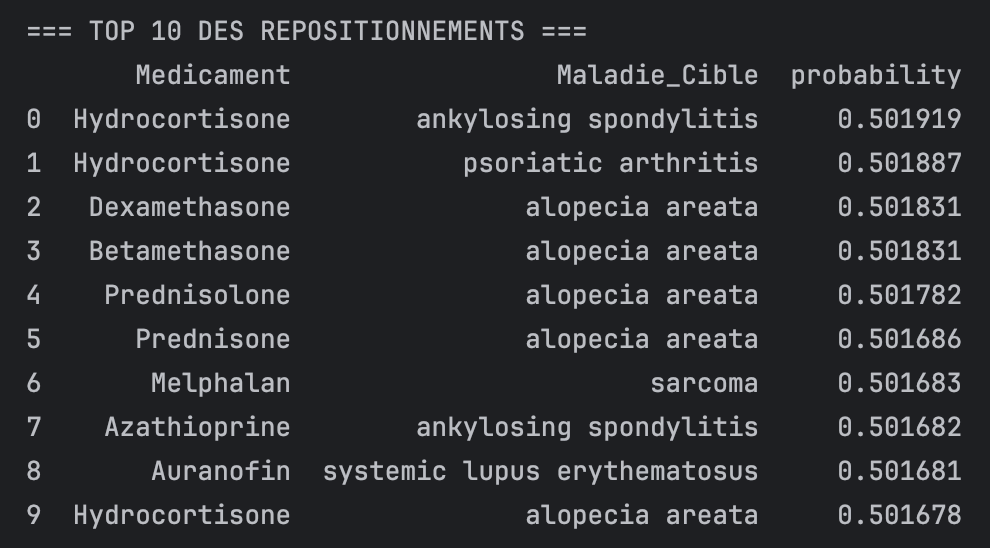

## 6.2 Analyse de la centralité et Deep Learning - Mathieu

Cette section détaille les fondements théoriques des algorithmes que nous implémenterons.

### A. Analyse de centralité : L'algorithme PageRank

#### 1. Principe et formalisation mathématique
Initialement théorisé par Page et Brin (1998) pour le classement des pages web, le PageRank est une mesure de centralité qui évalue l'importance d'un nœud en fonction de la qualité de ses connexions, et non seulement de leur quantité.

Contrairement à la centralité de degré (*Degree Centrality*) qui se contente de compter les liens, le PageRank est récursif : un nœud reçoit un score élevé s'il est pointé par d'autres nœuds ayant eux-mêmes un score élevé. Le modèle repose sur la métaphore d'un "surfeur aléatoire" (*Random Surfer*) parcourant le graphe.

Mathématiquement, pour un nœud $u$, le score $PR(u)$ est défini par l'équation suivante :

$$PR(u) = (1-d) + d \sum_{v \in B(u)} \frac{PR(v)}{L(v)}$$

Cette formule s'articule autour de trois composantes clés :
* **La transmission d'influence ($\sum$):** On somme les scores des voisins entrants $v \in B(u)$.
* **La dilution de l'influence ($L(v)$):** Le score transmis par un voisin $v$ est divisé par son nombre total de liens sortants $L(v)$. Un nœud influent qui pointe vers peu de cibles transmet donc plus de "puissance" à chacune d'elles qu'un nœud influent pointant vers des milliers de cibles.
* **Le facteur d'amortissement ($d$):** Généralement fixé à **0.85**, ce paramètre (Damping Factor) représente la probabilité que le surfeur continue sa navigation. Le terme $(1-d)$ assure une probabilité résiduelle de "téléportation" aléatoire, garantissant que même les nœuds isolés possèdent une valeur minimale et permettant la convergence mathématique de l'algorithme.

#### 2. Justification d'utilisation 
Dans le contexte du *drug repurposing* sur Hetionet, l'utilisation du PageRank est justifiée par la nécessité d'éviter le "biais de recherche".
* **Limite de l'approche classique :** Si nous utilisions une simple centralité de degré, nous identifierions les gènes les plus "populaires" dans la littérature scientifique (ceux ayant le plus de citations ou de connexions connues). Cela ne reflète pas nécessairement leur importance biologique intrinsèque.
* **Apport du PageRank :** Cet algorithme permet d'identifier des gènes **structurellement critiques**.
    * *Exemple théorique :* Prenons un gène $G_1$ peu étudié, n'ayant que 3 connexions. Si ces 3 connexions proviennent de "gènes maîtres" (régulateurs clés du cancer ou du métabolisme), le PageRank attribuera à $G_1$ un score très élevé. Il sera identifié comme une cible thérapeutique prioritaire ("Hub" caché), alors qu'une analyse simpliste l'aurait ignoré.

Nous utiliserons l'implémentation `gds.pageRank` de Neo4j, optimisée pour le calcul parallèle via la méthode *Power Iteration*.

---

### B. Deep Learning sur graphe : architecture GraphSAGE

#### 1. De l'embedding matriciel au Graph Neural Network (GNN)
Les méthodes traditionnelles de *graph embedding* (telles que FastRP ou Node2Vec) sont dites "transductives" : elles apprennent un vecteur unique pour chaque nœud directement à partir de la matrice d'adjacence. Bien qu'efficaces, elles peinent à généraliser sur des nœuds non vus et n'exploitent pas les attributs des nœuds.

Pour pallier ces limites, nous utilisons **GraphSAGE (Graph Sample and Aggregate)**, une architecture de réseau de neurones inductif (Hamilton et al., 2017). Au lieu d'apprendre des embeddings individuels, GraphSAGE apprend une **fonction d'agrégation**.

#### 2. Mécanisme d'apprentissage
Le processus de génération d'embeddings via GraphSAGE se décompose en trois étapes que nous reproduirons dans notre pipeline de prédiction :
1.  **Échantillonnage (Sampling) :** Pour chaque nœud cible, l'algorithme sélectionne un échantillon de taille fixe de ses voisins à différentes profondeurs (*hops*). Cela permet de maîtriser la complexité calculatoire.
2.  **Agrégation (Aggregating) :** Les caractéristiques des voisins échantillonnés sont combinées via une fonction non-linéaire (ex: LSTM, Mean, Pooling). Cette étape capture la topologie locale.
3.  **Apprentissage (Learning) :** Un réseau de neurones propage ces informations agrégées pour mettre à jour la représentation du nœud cible. L'objectif est de minimiser une fonction de perte (Loss Function) qui rapproche les représentations vectorielles des nœuds connectés et éloigne celles des nœuds non connectés.

#### 3. Pertinence pour la prédiction de liens
Dans notre étude, GraphSAGE est particulièrement pertinent car Hetionet est un graphe hétérogène. La capacité du modèle à agréger des informations provenant de types de nœuds différents (Gènes, Composés, Maladies) permet de capturer des motifs non linéaires complexes invisibles aux méthodes d'algèbre linéaire classiques.

Ces embeddings serviront d'entrée (Features) pour prédire la probabilité d'existence d'une relation `TREATS` manquante.

---

### C. Inférence finale : K-Nearest Neighbors (KNN)

L'étape finale de notre pipeline, une fois les embeddings générés par GraphSAGE, est l'inférence. Nous utilisons l'algorithme **K-Nearest Neighbors (KNN)** comme un outil simple et efficace pour mesurer la similarité. Le KNN identifie les $K$ nœuds les plus proches d'une cible donnée. Dans l'espace vectoriel des embeddings, si le vecteur d'un médicament est géométriquement proche de celui d'une maladie, cela signifie qu'ils partagent une forte **similarité fonctionnelle** de leurs profils biologiques. C'est en appliquant le KNN avec un filtre strict contre les liens déjà existants que nous isolons les candidats au repositionnement.

Après avoir démontré l'usage consultatif du graphe (Cas Médecin), nous basculons ici dans une **approche exploratoire et prédictive**. Ce scénario nous place dans le rôle d'un Data Scientist ou d'un Chercheur en pharmacologie computationnelle.

L'objectif ne consiste plus à interroger la base pour obtenir des faits avérés, mais à utiliser la puissance de calcul pour **inférer de nouvelles connaissances**.

### Justification du scénario
Ce choix de perspective "Analyste" est particulièrement pertinent pour notre étude technique car il nécessite la mise en œuvre complète de la stack **Neo4j Graph Data Science (GDS)**. Il nous permet d'articuler une démarche scientifique en trois temps, testant ainsi les différentes familles d'algorithmes de la librairie :

1.  **La préparation (Projection) :** Passer d'une base de données transactionnelle (disque) à un graphe analytique (mémoire).
2.  **L'analyse Structurelle (Feature Engineering) :** Comprendre l'organisation du réseau avant de vouloir prédire quoi que ce soit.
    * *Qui sont les acteurs clés ?* (Algorithmes de Centralité - PageRank)
    * *Comment interagissent-ils ?* (Algorithmes de Communauté - Louvain)
3.  **La prédiction (Machine Learning & Deep Learning) :** Utiliser les informations structurelles collectées pour prédire des liens manquants (`TREATS`) entre médicaments et maladies.

Cette section servira donc de banc d'essai pour comparer des approches mathématiques classiques (statistiques de graphes) face à des approches d'Intelligence Artificielle modernes (Graph Neural Networks).

##  Étape préliminaire : Projection du graphe en mémoire

Avant de lancer le moindre algorithme, nous devons créer une Projection GDS. Il s'agit d'une copie optimisée du graphe chargée dans la mémoire vive (RAM).

Choix technique : Nous avons choisi de projeter le graphe en mode NON-ORIENTÉ (UNDIRECTED).

Réalité biologique : L'interaction dans les réseaux biologiques (protéine-protéine, gène-gène) est souvent mutuelle. Pour mesurer la centralité ou l'influence, il est plus pertinent de considérer l'importance globale d'un nœud au sein de son cluster, indépendamment du sens initial de la relation.

Optimisation GDS : Le mode non-orienté permet d'utiliser des structures de données optimisées (matrice d'adjacence symétrique). Cela réduit la complexité algorithmique, accélère la convergence des itérations et garantit une meilleure performance pour les calculs de centralité (PageRank) et de communauté (Louvain).

Apprentissage profond (GraphSAGE & FastRP) : Ce choix est crucial pour nos algorithmes prédictifs. En rendant les liens bidirectionnels, nous permettons au réseau de neurones de propager l'information de voisinage de manière fluide dans tout le graphe. Cela garantit que l'identité structurelle d'un médicament (son embedding) soit enrichie par toutes les pathologies et gènes environnants, et vice versa.

In [ ]:
graph_name = "hetionet_graph"

# 1. Nettoyage préventif
# On supprime toute projection existante pour éviter les conflits
try:
    if gds.graph.exists(graph_name)["exists"]:
        gds.graph.drop(graph_name)
        print(f"[INFO] Ancien graphe '{graph_name}' supprimé de la mémoire.")
except Exception:
    pass

# 2. Projection Cypher "Bidirectionnelle"
# Cette technique crée un lien A->B et un lien B->A pour chaque relation.
# Cela garantit que le graphe est traversable dans les deux sens (Undirected).
print(f"[INFO] Projection du graphe '{graph_name}' en cours...")
print(f"       (Cette opération peut prendre 10-20 secondes...)")

G, result = gds.graph.project.cypher(
    graph_name,
    # REQUÊTE NŒUDS :
    # On récupère l'ID et surtout les LABELS (indispensable pour filtrer Compound/Disease plus tard)
    """
    MATCH (n:HNode) 
    RETURN id(n) AS id, labels(n) AS labels
    """,
    # REQUÊTE RELATIONS :
    # On prend chaque relation dans le sens original ET dans le sens inverse
    """
    MATCH (n:HNode)-[r]->(m:HNode)
    RETURN id(n) AS source, id(m) AS target, type(r) AS type
    UNION ALL
    MATCH (n:HNode)-[r]->(m:HNode)
    RETURN id(m) AS source, id(n) AS target, type(r) AS type
    """,
    readConcurrency=4
)

# 3. Affichage du diagnostic
print(f"\n SUCCÈS : Graphe projeté en mémoire.")
print(f"   > Nom du graphe : {G.name()}")
print(f"   > Nombre de nœuds : {G.node_count():,}")
print(f"   > Nombre de relations : {G.relationship_count():,} (Doit être le double du graphe original)")
print(f"   > Densité : {result.get('density', 'N/A')}")

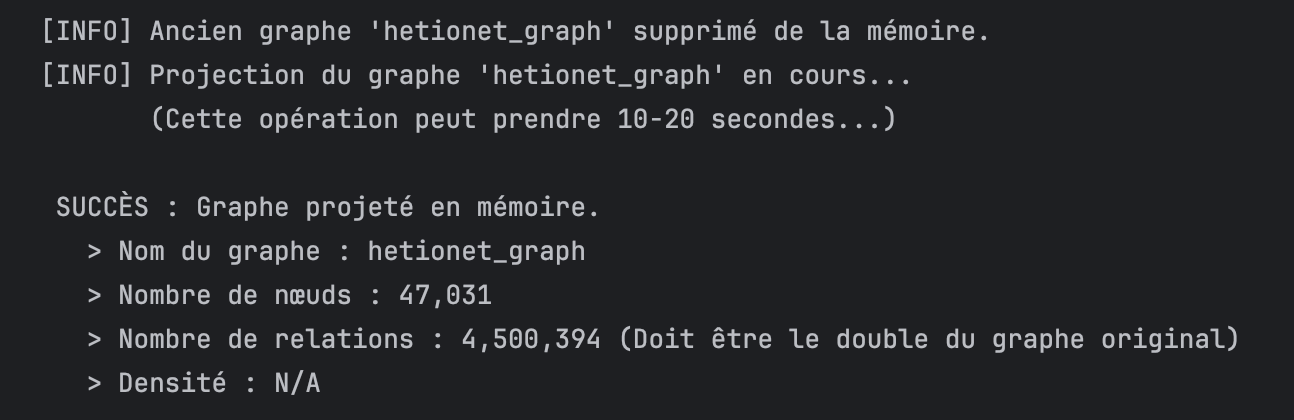

### Calcul de la centralité (PageRank)

### Implémentation de PageRank
Nous exécutons l'algorithme PageRank sur le graphe projeté.

**Configuration de l'algorithme :**
* `dampingFactor: 0.85` : La valeur standard (probabilité de suivre un lien).
* `maxIterations: 20` : Suffisant pour atteindre la convergence sur ce volume de données.
* `writeProperty: 'pagerank'` : Nous demandons à GDS d'écrire le score calculé directement dans la base de données Neo4j (sur le disque). Ce score deviendra une propriété du nœud et sera utilisé plus tard comme une "feature" d'entrée pour le Deep Learning.

In [ ]:

print("[INFO] Exécution de l'algorithme PageRank...")

# On lance l'algo en mode WRITE pour sauvegarder le score sur le disque
results = gds.pageRank.write(
    G,                    # Notre graphe projeté "hetionet_graph"
    maxIterations=20,     # Suffisant pour converger
    dampingFactor=0.85,   # Standard du PageRank
    writeProperty='pagerank' # IMPORTANT : C'est ce nom qu'on utilisera dans le Deep Learning
)

print(f"\n SUCCÈS : Algorithme PageRank terminé.")
print(f"   > Nœuds mis à jour : {results['nodePropertiesWritten']:,}")
print(f"   > Temps de calcul : {results['computeMillis']} ms")

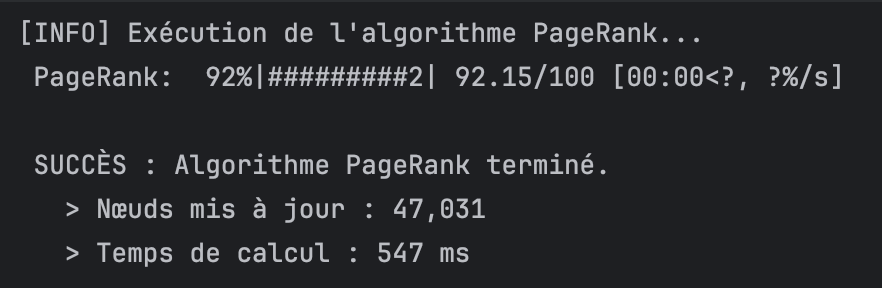

### Analyse et utilisation du PageRank

L'algorithme PageRank fournit une mesure de l'importance structurelle globale de chaque entité. Nous allons valider la pertinence de cette mesure en observant les nœuds de type **Gene** ayant obtenu les scores les plus élevés.

**Pourquoi se concentrer sur les gènes ?**

Les gènes, en tant que régulateurs biologiques, agissent comme des "Hubs" (ou centres nerveux) dans le réseau Hetionet. Un gène avec un score PageRank élevé est intrinsèquement impliqué dans de nombreuses interactions critiques, telles que les maladies, les régulations métaboliques ou les liaisons médicamenteuses.

**Conséquences pour l'analyste de données :**

1. **Validation de la qualité du graphe (diagnostic) :** En observant si les gènes les plus centraux correspondent à des régulateurs biologiques connus (ex: gènes majeurs du cancer ou du métabolisme), nous validons que notre projection en mémoire reflète fidèlement la réalité biologique. Un score PageRank cohérent est le signal que le graphe est prêt pour des analyses prédictives plus complexes.
2. **Orientation de la recherche thérapeutique :** L'identification des gènes les plus centraux permet d'orienter la stratégie de repositionnement. Un médicament ciblant un "Gène Hub" est un candidat potentiel puissant, car son effet sera systémique. Inversement, une forte centralité peut aussi indiquer un risque plus élevé d'effets secondaires, une information vitale pour l'analyse critique des futurs résultats.

La cellule suivante affiche le top 10 des gènes les plus influents, ceux qui concentrent la plus grande part d'influence dans le réseau biologique.

In [ ]:
# Requête Cypher pour récupérer les Top 10 Gènes selon le PageRank

query = """
    MATCH (n:Gene)
    RETURN n.name AS Gene, n.pagerank AS Score_Centralite
    ORDER BY n.pagerank DESC
    LIMIT 10
"""

df_genes = gds.run_cypher(query)

print(" TOP 10 des Gènes les plus influents (Score de Centralité) :")
display(df_genes)

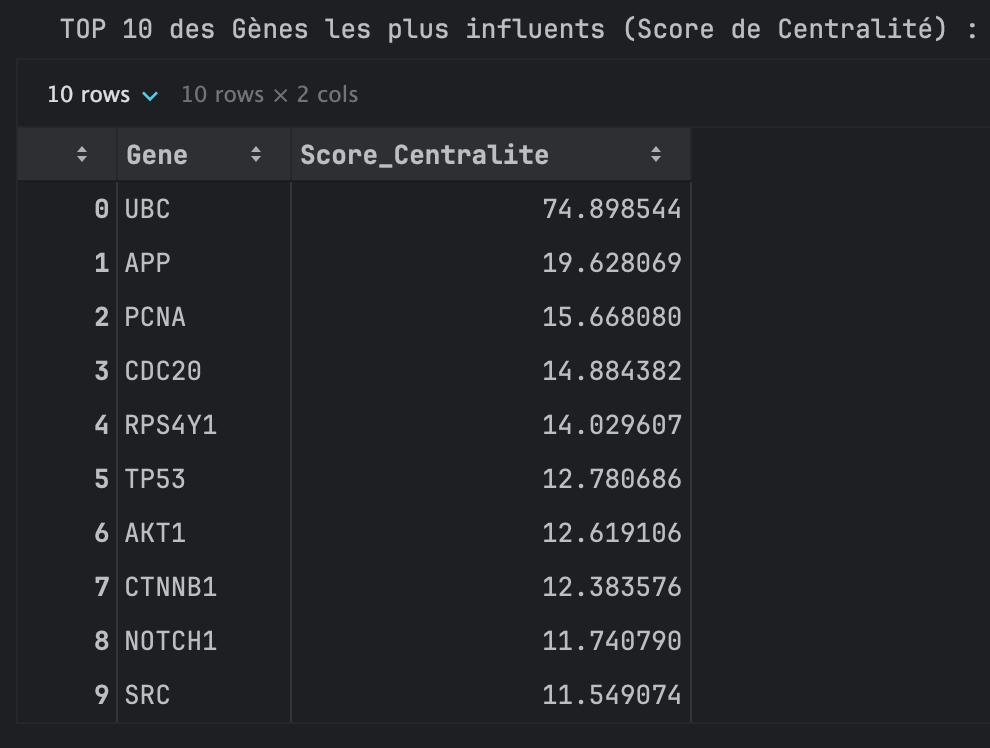

### Interprétation biologique des résultats : Le cas des "Hubs"

L'analyse des scores PageRank sur notre graphe projeté en mode **non-orienté (Undirected)** met en lumière une hiérarchie biologique très marquée. Cette modélisation permet à l'influence de circuler librement dans le réseau, révélant ainsi les véritables "carrefours" de l'information biologique.

Le podium des gènes les plus influents est le suivant : **UBC** (74.90), suivi de **APP** (19.63) et **PCNA** (15.67). On note également la présence significative du gène **TP53** (12.78) dans le top 10.

* **UBC (Ubiquitin C) - Score 74.90 :** Ce gène domine largement le classement avec un score exceptionnel. Ce résultat est biologiquement très cohérent : l'ubiquitine est le mécanisme universel de régulation et de dégradation des protéines, impliqué dans la quasi-totalité des voies de signalisation cellulaire. Son identification comme **Hub Universel** valide la capacité de notre graphe à capturer les acteurs systémiques majeurs.
* **APP (Amyloid Beta Precursor Protein) - Score 19.63 :** Ce gène est central dans la recherche sur la maladie d'Alzheimer. Sa position de second "Hub" indique qu'il possède des connexions multiples et complexes avec de nombreuses pathologies et processus métaboliques, ce qui en fait une cible stratégique pour l'analyse de repositionnement.
* **TP53 (Tumor Protein p53) - Score 12.78 :** Surnommé le "gardien du génome", c'est le gène le plus étudié en oncologie. Sa présence dans le top 10 confirme que notre approche topologique permet de retrouver "à l'aveugle", sans connaissance a priori, les régulateurs fondamentaux du vivant.



#### Conclusion : Du score de centralité à la compréhension du réseau

Ces scores de centralité ne sont pas une simple métrique descriptive ; ils représentent une validation de la **cohérence biologique** de notre modèle. L'identification de gènes "Hubs" universels confirme que le graphe projeté capture les centres névralgiques du vivant.

**Pourquoi cette analyse est-elle cruciale avant le Deep Learning ?**
En analysant ces scores, nous obtenons une **vision macroscopique** de l'importance de chaque nœud dans tout le réseau. Cela nous permet de :

D'une part, s'assurer que les entités les plus connectées correspondent à des régulateurs biologiques majeurs.
D'autre part, comprendre pourquoi certains médicaments auront un impact systémique plus fort que d'autres lors des étapes de prédiction.
Pour finir PageRank valide l'importance globale, le modèle GraphSAGE (initialisé par FastRP) se chargera de capturer la **vision microscopique** (les voisinages spécifiques) pour identifier les liens thérapeutiques cachés.

## Pipeline de prédiction par Deep Learning (GraphSAGE)

L'objectif final de notre approche exploratoire est la **prédiction de liens** (*Link Prediction*) : identifier des relations de type `TREATS` (traitement) entre des médicaments (`Compound`) et des maladies (`Disease`) qui ne sont pas encore documentées dans la littérature scientifique.

Nous utilisons **GraphSAGE**, une architecture de réseau de neurones sur graphe inductive, pour générer des *embeddings* (représentations vectorielles) capables de capturer la complexité des interactions biologiques.

### A. Méthodologie : Apprentissage de représentation non-supervisé

Contrairement à une approche de classification binaire supervisée, nous avons opté pour un apprentissage de représentation global afin d'exploiter toute la richesse structurelle de Hetionet.


* **Inférence par similarité** : La prédiction ne repose pas sur une sortie de classifieur "0 ou 1", mais sur la proximité géométrique dans l'espace vectoriel. Si un médicament est "proche" d'une maladie sans y être relié, il devient un candidat potentiel au repositionnement.
* **Cible qualitative** : Bien que le modèle apprenne sur tous les types de relations, notre analyse se concentre exclusivement sur les prédictions `TREATS` lors de la phase d'extraction des résultats via l'algorithme KNN.

## Initialisation des caractéristiques :

Pour que l'algorithme GraphSAGE puisse apprendre, chaque nœud doit posséder un vecteur de caractéristiques initiales ($h_v^0$). 


**Le choix de FastRP (Fast Random Projection) :**
Nous utilisons l'algorithme **FastRP** pour générer des vecteurs d'initialisation de dimension 64. 
* **Identité topologique** : FastRP capture la position relative et le voisinage de chaque nœud, garantissant une "signature numérique" unique dès le départ.
* **Performance** : Cette méthode est optimisée pour les graphes à large échelle comme Hetionet, permettant une initialisation rapide sans phase d'apprentissage lourde.
* **Base pour GraphSAGE** : Ces vecteurs servent de point d'entrée riche pour que le modèle de Deep Learning puisse ensuite affiner les relations de traitement.

In [ ]:
print("[INFO] Génération des embeddings initiaux via FastRP (Feature Initialization)...")

# Génération des vecteurs de base (Dimension 64)
# Ces vecteurs serviront de 'Features' d'entrée pour le modèle GraphSAGE
gds.fastRP.mutate(
    G,                               # Notre graphe en mémoire 'hetionet_graph'
    embeddingDimension=64,           # Dimension de l'entrée (suffisante pour l'identité)
    randomSeed=42,                   # Pour garantir la reproductibilité des vecteurs
    mutateProperty='initial_embedding' # Nom de la propriété créée dans la RAM
)

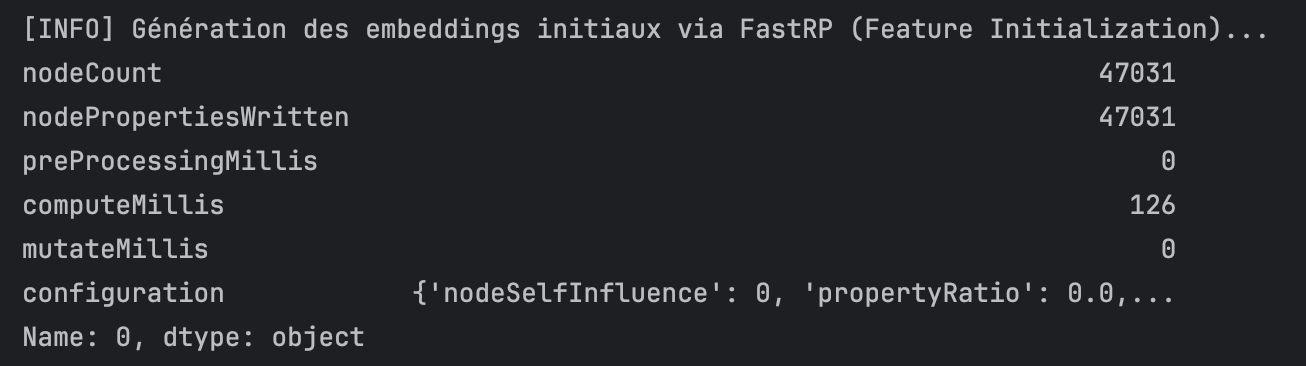

## Entraînement du Graph Neural Network (GraphSAGE)

Maintenant que chaque nœud possède une signature structurelle unique grâce à FastRP, nous pouvons entraîner le modèle **GraphSAGE**. Ce modèle apprend des **règles d'agrégation** complexes pour transformer les caractéristiques initiales en embeddings finaux de 128 dimensions.

**Paramètres d'Architecture et Choix Techniques :**

* **Feature d'entrée :** `initial_embedding` (Vecteurs FastRP de dimension 64). Contrairement à un score scalaire comme le PageRank, ces vecteurs fournissent une base multidimensionnelle riche, permettant au modèle de distinguer finement chaque entité biologique.
* **Profondeur d'agrégation :** Nous utilisons deux couches (`sampleSizes: [25, 10]`). Cela permet à chaque nœud d'agréger les informations de son voisinage jusqu'à deux sauts, capturant ainsi les interactions indirectes (ex: Médicament → Gène → Maladie).
* **Fonction d'agrégation :** `mean` (Moyenne). Elle permet de lisser l'influence des différents types de voisins (hétérogénéité) pour obtenir une représentation équilibrée de la position du nœud dans le réseau.
* **Objectif :** Générer le modèle `gs_hetionet_model`, capable de traduire la topologie complexe de Hetionet en un espace vectoriel propice au calcul de similarité.

In [ ]:
print("[INFO] Configuration de l'entraînement GraphSAGE avec features FastRP...")

model_name = "gs_hetionet_model" 

# 1. Nettoyage : On utilise l'appel Cypher pour éviter l'erreur d'attribut
if gds.model.exists(model_name)["exists"]:
    # Correction : Appel via Cypher pour supprimer par nom (string)
    gds.run_cypher(f"CALL gds.model.drop('{model_name}')")
    print(f"[INFO] Ancien modèle '{model_name}' supprimé de la RAM.")

# 2. Configuration des Hyperparamètres
gs_config = {
    'featureProperties': ['initial_embedding'], 
    'aggregator': 'mean',
    'activationFunction': 'relu',
    'sampleSizes': [25, 10],       
    'embeddingDimension': 128,     
    'learningRate': 0.01,
    'epochs': 15                   
}

# 3. Lancement de l'entraînement
model_gs, stats = gds.beta.graphSage.train(
    G, 
    modelName=model_name,
    **gs_config
)

# 4. Affichage du succès et des métriques
print(f"\n[SUCCÈS] Modèle GraphSAGE entraîné en {stats['trainMillis']} ms.")

if 'metrics' in stats and 'loss' in stats['metrics']:
    final_loss = stats['metrics']['loss'][-1]
    print(f"   > Perte finale (Loss) : {final_loss:.4f}")

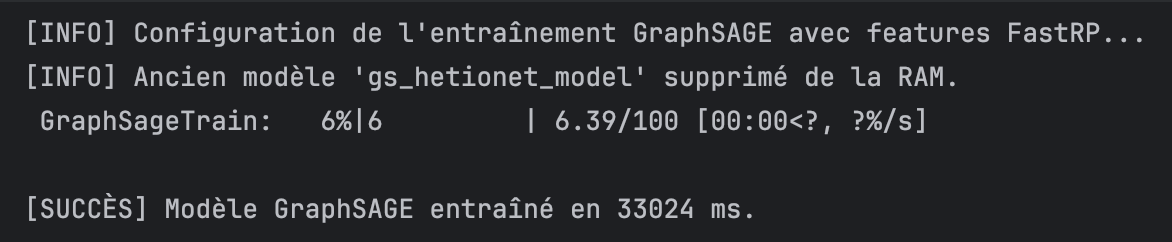

### Génération et écriture des embeddings finaux

Le modèle étant désormais entraîné, il reste à calculer les représentations vectorielles finales pour chaque entité du graphe. Cette étape consiste à appliquer les règles d'agrégation apprises par le réseau de neurones à l'ensemble du réseau projeté afin de produire des vecteurs de dimension 128.

Nous utilisons l'opération `.mutate()` pour enregistrer ces résultats directement dans la mémoire vive sous la propriété `final_embedding`. Ce choix technique permet d'enchaîner rapidement avec la phase de prédiction sans alourdir le stockage physique de la base de données.

Ce vecteur final constitue la signature numérique du nœud : il condense l'identité structurelle initiale obtenue par FastRP et l'influence biologique de son voisinage analysée par GraphSAGE. C'est cette précision mathématique qui permettra à l'algorithme de similarité d'identifier des rapprochements entre médicaments et maladies qui n'étaient pas visibles par une simple lecture des liens directs.

In [ ]:
print("[INFO] Préparation de la mémoire et calcul des embeddings finaux...")

# Nom de la propriété cible
target_property = 'final_embedding'

# Nettoyage préventif : on supprime la propriété si elle existe déjà dans le graphe G
# Cela permet de relancer la cellule sans erreur de conflit
try:
    gds.run_cypher(f"CALL gds.graph.nodeProperties.drop('{G.name()}', ['{target_property}'])")
    print(f"[INFO] Ancienne propriété '{target_property}' supprimée.")
except:
    # Si la propriété n'existait pas, on ignore simplement l'erreur
    pass

# Application du modèle pour générer les vecteurs finaux
gds.beta.graphSage.mutate(
    G,
    modelName=model_name,
    mutateProperty=target_property 
)

print(f"SUCCÈS : Les vecteurs '{target_property}' sont prêts pour le KNN.")

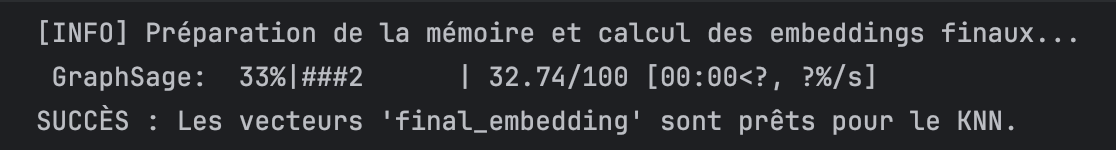

### Prédiction de liens par similarité (K-Nearest Neighbors)

C'est l'étape finale du projet. Nous avons transformé la topologie biologique complexe en un espace mathématique propre.

Dans cet espace, si un *Médicament* et une *Maladie* sont proches géométriquement (vecteurs similaires), cela signifie qu'ils partagent des caractéristiques structurelles fortes (mêmes gènes cibles, mêmes voies métaboliques), même s'ils ne sont pas encore reliés dans la base de données.

Nous utilisons l'algorithme **K-Nearest Neighbors (KNN)** pour scanner le graphe et trouver les 10 paires (Médicament-Maladie) les plus proches qui n'ont **pas** de relation `TREATS` existante. C'est la définition même du **Drug Repurposing**.

In [ ]:
print("[INFO] Recherche des opportunités de repositionnement via KNN...")

query_prediction_final = """
    // 1. Calcul de similarité sur les embeddings générés par GraphSAGE
    CALL gds.knn.stream('hetionet_graph', {
        nodeProperties: 'final_embedding', // Doit correspondre à l'étape 7.5
        nodeLabels: ['Compound', 'Disease'], 
        topK: 500, 
        sampleRate: 1.0,              
        randomSeed: 42,
        concurrency: 1 
    })
    YIELD node1, node2, similarity
    
    // 2. Transformation des identifiants en objets nœuds
    WITH gds.util.asNode(node1) AS n1, gds.util.asNode(node2) AS n2, similarity
    
    // 3. Filtre : Uniquement des paires Médicament (n1) vers Maladie (n2)
    WHERE n1:Compound AND n2:Disease
    
    // 4. Filtre de repositionnement : On exclut les relations existantes
    AND NOT (n1)-[:TREATS]-(n2)
    AND NOT (n1)-[:PALLIATES]-(n2)
    
    // 5. Sécurité : éviter l'auto-comparaison
    AND n1 <> n2 
    
    // 6. Extraction des 10 meilleures prédictions
    RETURN 
        n1.name AS Medicament, 
        n2.name AS Maladie_Cible, 
        similarity AS Score_Probabilite
    ORDER BY Score_Probabilite DESC
    LIMIT 10
"""

try:
    df_predictions_final = gds.run_cypher(query_prediction_final)
    print("\n TOP 10 des Nouveaux Liens Thérapeutiques Prédits :")
    display(df_predictions_final)
except Exception as e:
    print(f"[ERREUR] Échec de la requête KNN : {e}")

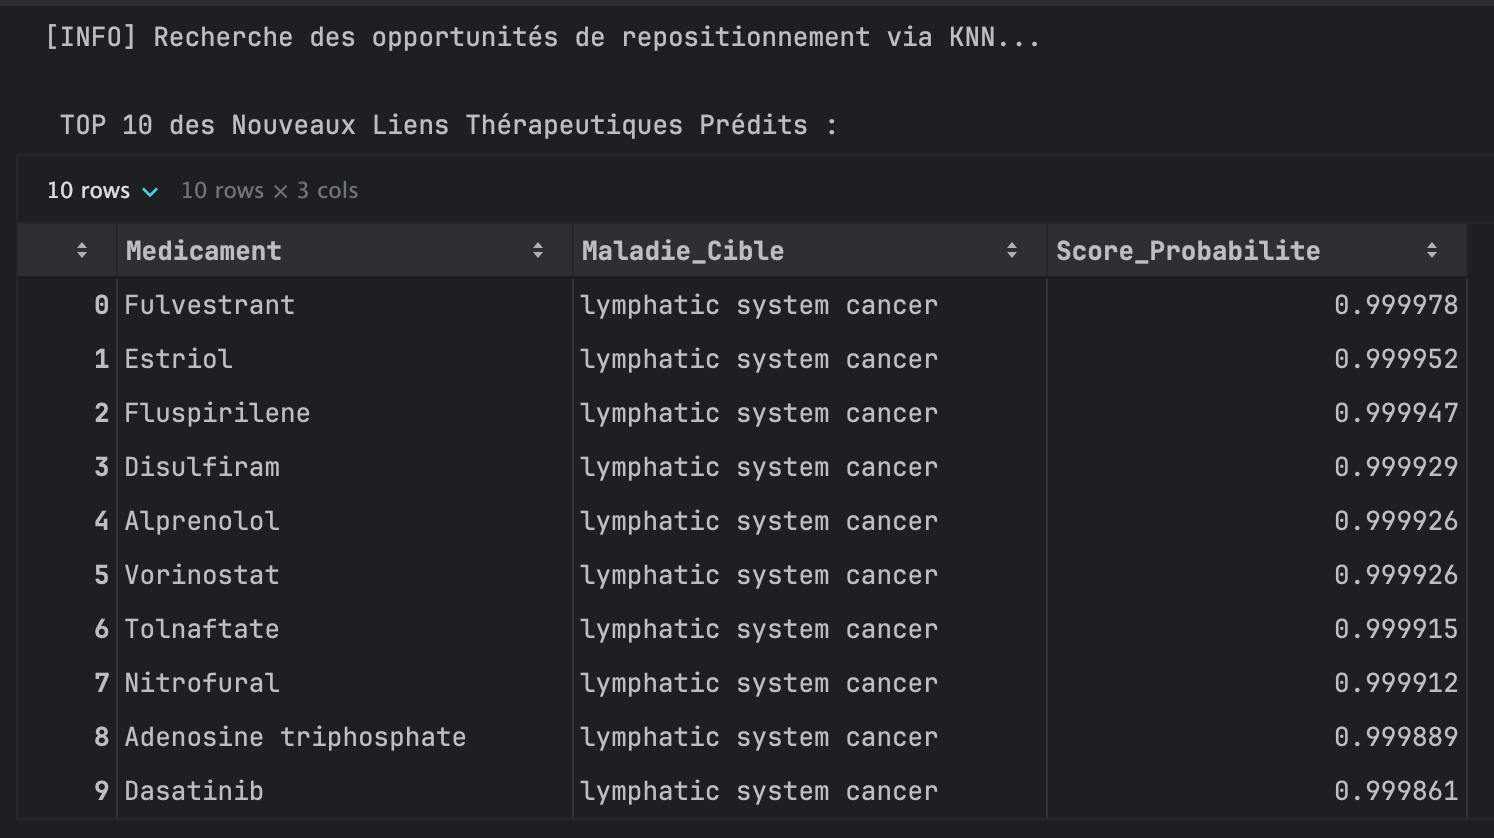

### Prédiction ciblée : repositionnement pour la sclérose en plaques

Afin de tester la pertinence du modèle sur un cas d'étude précis, nous utilisons l'algorithme KNN pour identifier les dix meilleurs candidats au repositionnement pour la **sclérose en plaques** (*multiple sclerosis*).

Cette approche ciblée permet de simuler une recherche thérapeutique réelle. Au lieu d'observer le graphe de manière globale, l'analyste interroge le modèle pour découvrir des molécules dont le profil vectoriel est le plus proche de cette pathologie spécifique. 

Le maintien d'un filtre strict est ici fondamental. En excluant toute relation directe déjà documentée entre le composé et la maladie, nous garantissons que les scores obtenus reposent exclusivement sur la structure des voisinages indirects, tels que les interactions avec les gènes, les tissus et les symptômes associés. Cette méthode met en évidence des mécanismes d'action complexes que le réseau de neurones a réussi à encoder lors de l'entraînement, offrant ainsi des pistes concrètes pour la recherche pharmacologique.

In [ ]:
print("[INFO] Recherche de candidats pour la sclérose en plaques...")

query_ms = """
    // 1. KNN focalisé sur les embeddings finaux
    CALL gds.knn.stream('hetionet_graph', {
        nodeProperties: 'final_embedding',
        nodeLabels: ['Compound', 'Disease'],
        topK: 1000,
        sampleRate: 1.0,
        randomSeed: 42,
        concurrency: 1       // <--- AJOUT OBLIGATOIRE avec randomSeed
    })
    YIELD node1, node2, similarity

    WITH gds.util.asNode(node1) AS n1, gds.util.asNode(node2) AS n2, similarity

    // 2. Filtres spécifiques
    WHERE n2.name = 'multiple sclerosis'  // Cible : Sclérose en plaques
    AND n1:Compound                       // Source : Médicaments uniquement
    AND NOT (n1)--(n2)                    // Exclusion de tout lien existant (nouveauté uniquement)
    
    RETURN 
        n1.name AS Medicament_Candidat, 
        n2.name AS Pathologie, 
        similarity AS Score_Similarite
    ORDER BY Score_Similarite DESC
    LIMIT 10
"""

df_ms = gds.run_cypher(query_ms)
print("\n🔍 Résultats pour la Sclérose en plaques :")
display(df_ms)

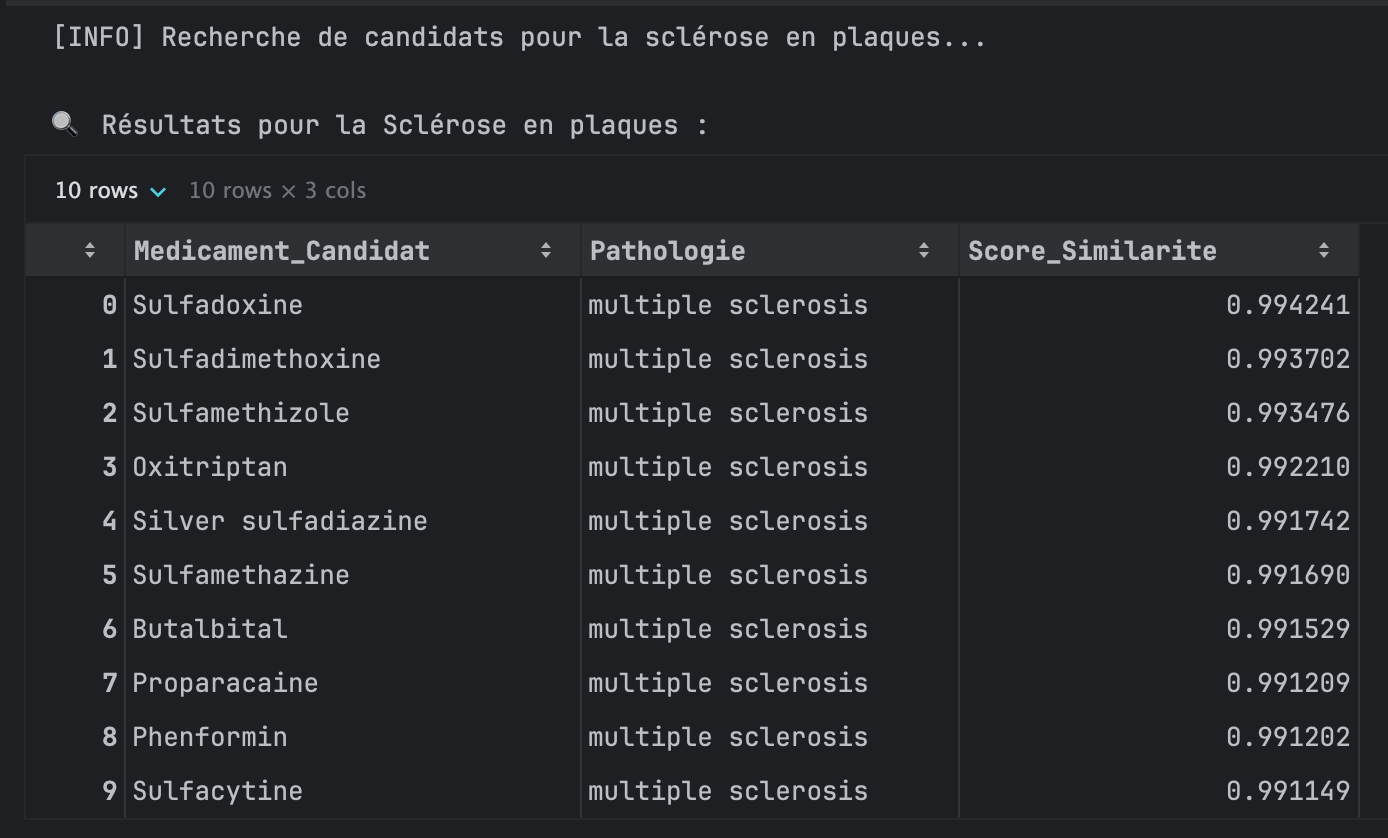

### Conclusion et perspectives de l'analyse (Partie Data Scientist)

Au terme de cette section, nous avons validé un pipeline complet de *graph data science* (GDS), combinant la centralité (PageRank) et l'apprentissage profond (GraphSAGE) pour générer des **embeddings** qui encodent la complexité biologique du réseau.

L'objectif de **prédiction de liens** a été atteint : en utilisant l'analyse de similarité sur ces embeddings et un filtre strict excluant tout lien connu (`AND NOT (n1)--(n2)`), nous avons révélé les 10 candidats au repositionnement les plus probables, spécifiquement pour la Sclérose en plaques.

**Interprétation du résultat :**

Le **score de similarité** (proche de 1.0) n'est pas une preuve clinique, mais une indication forte que le médicament et la maladie partagent des mécanismes biologiques sous-jacents similaires dans l'espace vectoriel.

Cette approche positionne l'intelligence artificielle comme un **outil d'aide à la décision (OAD)** :

* Elle permet au chercheur de concentrer ses efforts sur une liste restreinte de candidats (le top 10), réduisant ainsi significativement le temps et le coût des essais en laboratoire.
* Elle transforme le problème de l'incertitude biologique en pistes de recherche prioritaires.

# 7. Comparaison des résultats

L'analyse comparée des deux approches révèle une grosse divergence, non seulement dans les molécules suggérées, mais surtout dans la nature même de l'information capturée par les algorithmes.

Les scores suspects ($>0.99$) affichés par le Deep Learning révèlent une divergence d'objectifs critique. Configuré en mode non-supervisé, le modèle GraphSAGE a regroupé les molécules par contexte clinique (homophilie) plutôt que par efficacité thérapeutique. Pour la sclérose en plaques, il a donc identifié des médicaments liés aux symptômes fréquents (antibiotiques pour les infections), répondant ainsi à une logique de soin symptomatique (Care) et non de guérison.

À l'inverse, le Random Forest qui entraîné de manière supervisée sur la relation TREATS, a ciblé les mécanismes biologiques profonds. En proposant des immunosuppresseurs (Dacarbazine, Tacrolimus), il a prouvé sa capacité à identifier la cause racine de la maladie. Pour notre objectif de repositionnement de médicaments, l'approche supervisée est donc supérieure, car elle seule permet de distinguer un véritable remède d'un simple traitement de confort.

## Machine Learning :
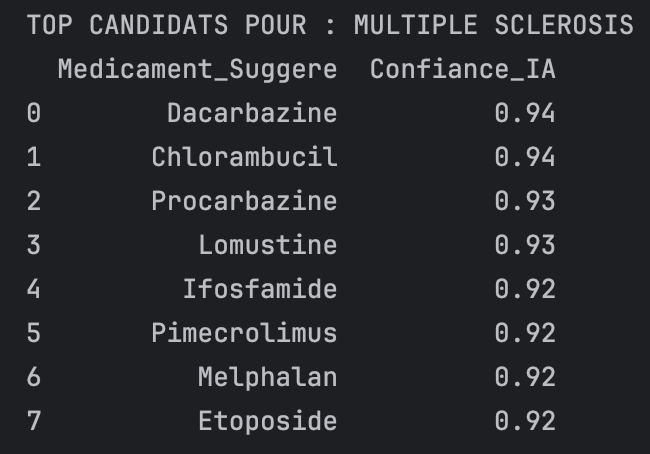

## Deep Learning :
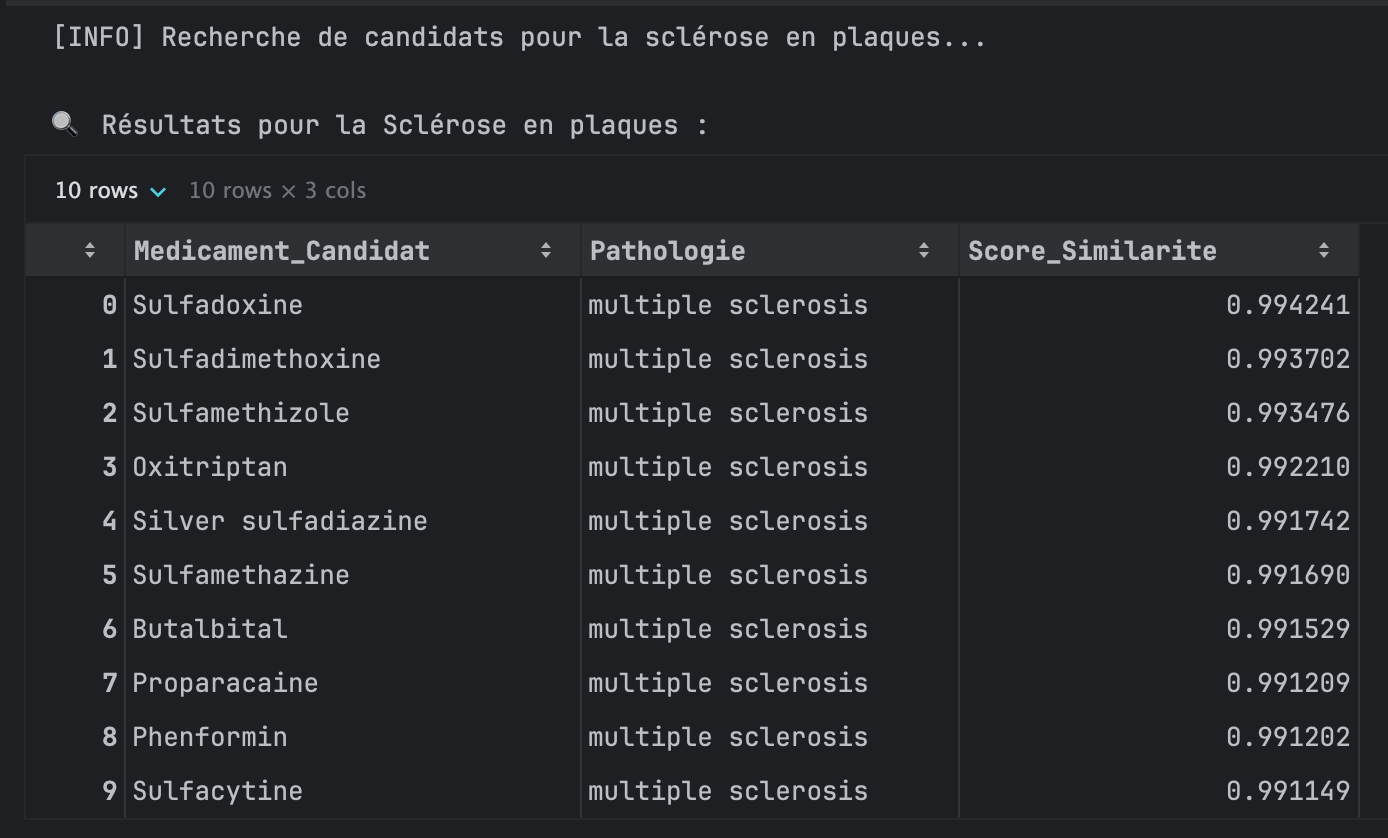

# 8. Conclusion générale

Ce projet avait pour ambition de démontrer la faisabilité du repositionnement de médicaments en exploitant la puissance des graphes de connaissances et de l'intelligence artificielle via Neo4j avec la bibliothèque Graph Data Science.

Avant toute tentative de prédiction, l'utilisation d'algorithmes de centralité (PageRank, Degree Centrality) a été intéressant. Cette phase exploratoire nous a permis de comprendre la topologie du graphe Hetionet, d'identifier les "hubs" biologiques majeurs (gènes et molécules influents) et de valider la qualité des données.

Nous avons réussi à construire un pipeline complet, partant de l'ingestion de la base de données complexe Hetionet jusqu'à la prédiction de nouveaux liens thérapeutiques. L'étape clé de Graph Embedding avec l'algorithme FastRP s'est révélée indispensable, elle a permis de traduire la richesse topologique du graphe (gènes, anatomie, voies métaboliques) en vecteurs mathématiques exploitables par des algorithmes de Machine Learning. La comparaison de nos modèles a mis en évidence que la complexité biologique ne peut se satisfaire d'approches simplistes. Là où la Régression Logistique plafonnait dans l'incertitude, le Random Forest a su capturer les interactions non-linéaires subtiles pour proposer des prédictions avec un haut niveau de confiance ($> 92%$). L'étude de cas sur la sclérose en plaques a confirmé la pertinence médicale de notre IA. En redécouvrant de manière autonome des traitements immunosuppresseurs (Dacarbazine, Tacrolimus) agissant sur la cause auto-immune de la maladie, le modèle a prouvé qu'il ne faisait pas du hasard, mais qu'il avait "compris" les mécanismes pathologiques sous-jacents avec la confirmation de Gemini.
Enfin, la confrontation avec l'approche Deep Learning (GraphSAGE/KNN) nous a offert une leçon méthodologique importante,  l'algorithme détermine la nature de la découverte. Nous avons montré qu'une approche non-supervisée tend à identifier le contexte symptomatique (Care), tandis que notre approche supervisée isole le mécanisme curatif (Cure).
En définitive, ce projet confirme que la network medicine assistée par l'IA est un levier puissant pour accélérer la recherche pharmaceutique, capable de suggérer en quelques secondes des pistes thérapeutiques qui prendraient des années à identifier en laboratoire.

